## Final Project Submission

Please fill out:
* Student name: Qilun Chen, Evan Serrano 
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Praveen Gowtham, Joe Comeaux
* Blog post URL:https://github.com/SerranoEvan/dsc-phase-2-project-v2-3


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

# Data cleaning

In [2]:
data = pd.read_csv('data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [4]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
view              object
condition         object
grade             object
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

change sqft_basement from object to float

In [5]:
data.loc[:, 'sqft_basement'] = data['sqft_basement'].str.replace("?","0.0")
data.loc[:, 'sqft_basement'] = data['sqft_basement'].astype('float64')

replace NaN in view to NONE

In [6]:
data['view'] = data['view'].fillna('NONE')

replace NaN in waterfront to NO

In [7]:
data['waterfront'] = data['waterfront'].fillna('NO')

replace NaN in yr_renovated to 0

In [8]:
data['yr_renovated'] = data['yr_renovated'].fillna(0)

check how many NaN in data

In [9]:
data.isna().sum().sum()

0

drop lat column and long column in data

In [10]:
data.drop(columns = 'lat', inplace = True)

In [11]:
data.drop(columns = 'long', inplace = True)

chreate new columns propertyTaxPerYear, livingAreaRatio, year_sold, houseAge, pricePerSqft

In [12]:
data['propertyTaxPerYear'] = data['price'] * 0.0101

In [13]:
data['livingAreaRatio'] = data['sqft_living'] / data['sqft_lot']

In [14]:
data['date'] = pd.to_datetime(data['date'])
data['year_sold'] = data['date'].dt.year

In [15]:
data['houseAge'] = data['year_sold'] - data['yr_built']

In [16]:
data['pricePerSqft'] = data['price'] / data['sqft_lot']

change columns waterfront, view, condition, grade to Ordinal encoding

In [17]:
data['waterfront'] = pd.get_dummies(data['waterfront'], drop_first = True)

In [18]:
data['view'] = data['view'].astype('category')

In [19]:
data['view'] = data['view'].cat.reorder_categories(['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'])


In [20]:
data['view'] = data['view'].cat.codes


In [21]:
data['condition'] = data['condition'].astype('category')

In [22]:
data['condition'] = data['condition'].cat.codes

In [23]:
data['grade'] = data['grade'].astype('category')

In [24]:
data['grade'] = data['grade'].cat.codes


# how home rebuilt might increase the estimated value of their homes, and by what amount.

## Understand factors affecting price

In [25]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'propertyTaxPerYear', 'livingAreaRatio',
       'year_sold', 'houseAge', 'pricePerSqft'],
      dtype='object')

drop some too obviously correlated columns.

In [26]:
df = data.drop(columns= ['id', 'date', 'propertyTaxPerYear', 'pricePerSqft', 'zipcode','year_sold','yr_built','yr_renovated' ])

only looking for brand new houses.

In [27]:
df = df[df['houseAge'] < 1]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 42 to 21589
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            442 non-null    float64
 1   bedrooms         442 non-null    int64  
 2   bathrooms        442 non-null    float64
 3   sqft_living      442 non-null    int64  
 4   sqft_lot         442 non-null    int64  
 5   floors           442 non-null    float64
 6   waterfront       442 non-null    uint8  
 7   view             442 non-null    int8   
 8   condition        442 non-null    int8   
 9   grade            442 non-null    int8   
 10  sqft_above       442 non-null    int64  
 11  sqft_basement    442 non-null    float64
 12  sqft_living15    442 non-null    int64  
 13  sqft_lot15       442 non-null    int64  
 14  livingAreaRatio  442 non-null    float64
 15  houseAge         442 non-null    int64  
dtypes: float64(5), int64(7), int8(3), uint8(1)
memory usage: 46

X is now our feature matrix
y is a vector of targets our outcomes.

In [29]:
X = df.drop(columns = ['price'])
Y = df['price']

In [30]:
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,livingAreaRatio,houseAge
42,5,2.75,3595,5639,2.0,0,0,0,10,3595,0.0,3625,5639,0.637524,0
63,3,1.75,1540,1044,3.0,0,0,0,9,1540,0.0,1580,3090,1.475096,0
133,3,2.50,2010,2287,2.0,0,0,0,9,1390,620.0,1690,1662,0.878881,0
139,3,2.25,1170,1249,3.0,0,0,0,9,1170,0.0,1350,1310,0.936749,0
211,3,2.25,1270,1566,2.0,0,0,0,9,1060,210.0,1160,1327,0.810983,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,4,2.75,2770,3852,2.0,0,0,0,9,2770,0.0,1810,5641,0.719107,0
21580,5,2.75,3600,9437,2.0,0,0,0,10,3600,0.0,3550,9421,0.381477,0
21582,4,2.50,3118,7866,2.0,0,2,0,10,3118,0.0,2673,6500,0.396390,0
21586,3,1.75,1500,11968,1.0,0,0,0,7,1500,0.0,1320,11303,0.125334,0


Checking for collinearity through the correlation matrix

In [31]:
X.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,livingAreaRatio,houseAge
bedrooms,1.000000,0.579423,0.707657,0.276501,-0.248584,-0.058851,0.074252,NaN,-0.087943,0.697206,0.086949,0.534356,0.264687,-0.500899,0.096395
bathrooms,0.579423,1.000000,0.711370,0.327647,-0.166322,0.085994,0.190201,NaN,-0.330452,0.608755,0.345810,0.462372,0.292468,-0.374677,0.087670
sqft_living,0.707657,0.711370,1.000000,0.474060,-0.236272,0.105931,0.304155,NaN,-0.313127,0.937606,0.255272,0.743208,0.441135,-0.545118,0.078584
sqft_lot,0.276501,0.327647,0.474060,1.000000,-0.194044,0.025984,0.098258,NaN,-0.210978,0.477177,0.040824,0.372969,0.929182,-0.489977,0.039175
floors,-0.248584,-0.166322,-0.236272,-0.194044,1.000000,-0.022918,-0.025207,NaN,0.025322,-0.187346,-0.176686,-0.223660,-0.171912,0.521961,-0.068353
waterfront,-0.058851,0.085994,0.105931,0.025984,-0.022918,1.000000,0.564074,NaN,-0.158994,0.050681,0.165940,0.104012,-0.000945,-0.029351,0.011263
view,0.074252,0.190201,0.304155,0.098258,-0.025207,0.564074,1.000000,NaN,-0.243251,0.190360,0.314606,0.281716,0.076188,-0.037313,-0.028815
condition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
grade,-0.087943,-0.330452,-0.313127,-0.210978,0.025322,-0.158994,-0.243251,NaN,1.000000,-0.266339,-0.139315,-0.153827,-0.261389,0.146853,0.032093
sqft_above,0.697206,0.608755,0.937606,0.477177,-0.187346,0.050681,0.190360,NaN,-0.266339,1.000000,-0.089875,0.745605,0.448726,-0.612846,0.107616


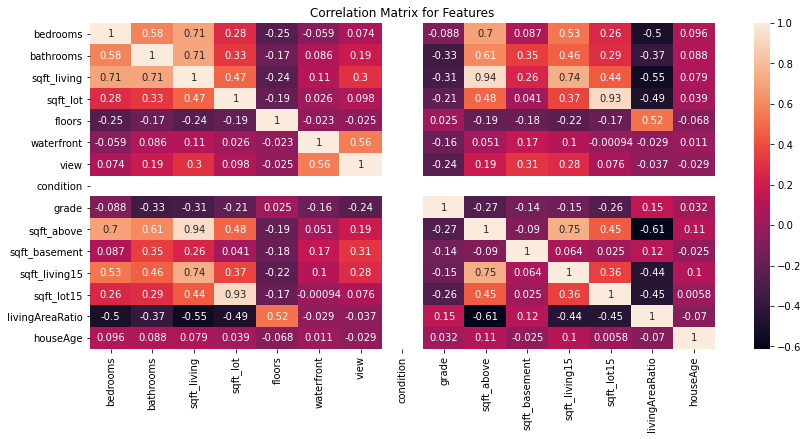

In [32]:
plt.figure(figsize = (14, 6))
sns.heatmap(X.corr(), annot = True)

plt.title('Correlation Matrix for Features')
plt.savefig("corrmat.jpg" , dpi=300)
plt.show()

Highly correlated variables:
bathrooms vs sqft_living
bedrooms vs sqft_living
sqft_lot vs sqft_lot15
sqft_living vs sqft_living15
sqft_above vs sqft_living
getting rid of:
sqft_above
condition
sqft_lot15
sqft_living15
houseAge

In [33]:
X = X.drop(columns = ['condition', 'sqft_lot15', 'sqft_living15', 'houseAge', 'sqft_above'])
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_basement,livingAreaRatio
42,5,2.75,3595,5639,2.0,0,0,10,0.0,0.637524
63,3,1.75,1540,1044,3.0,0,0,9,0.0,1.475096
133,3,2.50,2010,2287,2.0,0,0,9,620.0,0.878881
139,3,2.25,1170,1249,3.0,0,0,9,0.0,0.936749
211,3,2.25,1270,1566,2.0,0,0,9,210.0,0.810983


looking the heatmap again

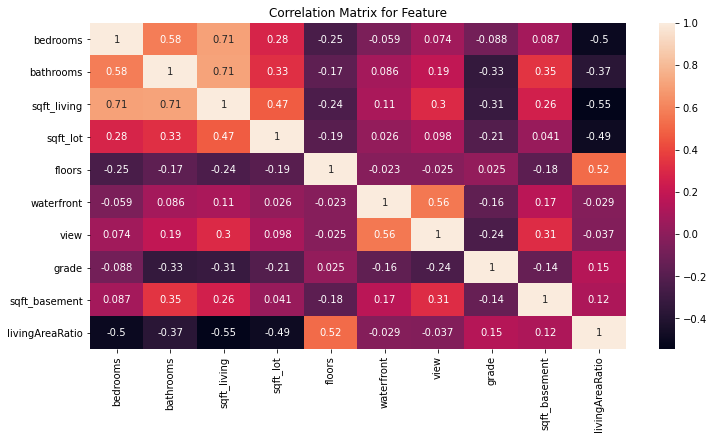

In [34]:
plt.figure(figsize = (12,6))
sns.heatmap(X.corr(), annot = True)

plt.title('Correlation Matrix for Feature')
plt.savefig("corrmat.jpg" , dpi=300)
plt.show()

## multivariate linear regression

Code is the exact

In [35]:
X_augmented = sm.add_constant(X)
X_augmented

,const,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_basement,livingAreaRatio
42,1.0,5,2.75,3595,5639,2.0,0,0,10,0.0,0.637524
63,1.0,3,1.75,1540,1044,3.0,0,0,9,0.0,1.475096
133,1.0,3,2.50,2010,2287,2.0,0,0,9,620.0,0.878881
139,1.0,3,2.25,1170,1249,3.0,0,0,9,0.0,0.936749
211,1.0,3,2.25,1270,1566,2.0,0,0,9,210.0,0.810983
...,...,...,...,...,...,...,...,...,...,...,...
21575,1.0,4,2.75,2770,3852,2.0,0,0,9,0.0,0.719107
21580,1.0,5,2.75,3600,9437,2.0,0,0,10,0.0,0.381477
21582,1.0,4,2.50,3118,7866,2.0,0,2,10,0.0,0.396390
21586,1.0,3,1.75,1500,11968,1.0,0,0,7,0.0,0.125334


In [36]:
results = sm.OLS(Y, X_augmented).fit()

Get the slopes for each variable and the constant term:

In [37]:
results.params

const             -2.293989e+05
bedrooms          -4.966799e+04
bathrooms          7.862214e+04
sqft_living        2.554534e+02
sqft_lot           5.641941e+00
floors             1.101355e+05
waterfront         1.502304e+06
view              -7.116770e+04
grade             -2.327080e+04
sqft_basement      1.295782e+02
livingAreaRatio    1.672241e+05
dtype: float64

Get the R square value.

In [38]:
results.rsquared

0.6500261002413503

In [39]:
results.rsquared_adj

0.6419060561634233

In [40]:
X.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_basement,livingAreaRatio
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,3.737557,2.732466,2631.117647,5524.343891,2.132353,0.004525,0.085973,8.257919,170.183258,0.690264
std,0.845901,0.602436,926.377305,6937.332563,0.389800,0.067191,0.468347,3.081139,319.225871,0.348565
min,1.000000,1.000000,710.000000,638.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.039498
25%,3.000000,2.500000,1760.000000,2214.500000,2.000000,0.000000,0.000000,9.000000,0.000000,0.450979
50%,4.000000,2.500000,2670.000000,4835.000000,2.000000,0.000000,0.000000,9.000000,0.000000,0.600987
75%,4.000000,3.250000,3279.250000,6539.750000,2.000000,0.000000,0.000000,10.000000,207.500000,0.861017
max,6.000000,5.000000,5790.000000,108865.000000,3.000000,1.000000,4.000000,10.000000,1360.000000,2.089762


In [41]:
def standardizer(col):
    col_standardized = (col - col.mean())/col.std()
    return col_standardized

standardized the columns

In [42]:
X_standard = X.apply(lambda x : (x-x.mean())/x.std())

In [43]:
X_standard.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_basement,livingAreaRatio
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-4.018907e-17,-1.054963e-16,1.165483e-16,2.813235e-17,9.645377e-17,1.205672e-17,-1.607563e-17,-3.134747e-16,-8.037814e-18,3.496449e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.236263e+00,-2.875769e+00,-2.073796e+00,-7.043549e-01,-2.904958e+00,-6.734368e-02,-1.835664e-01,-2.680151e+00,-5.331124e-01,-1.866986e+00
25%,-8.719188e-01,-3.858769e-01,-9.403486e-01,-4.771061e-01,-3.395406e-01,-6.734368e-02,-1.835664e-01,2.408465e-01,-5.331124e-01,-6.864860e-01
50%,3.102533e-01,-3.858769e-01,4.197248e-02,-9.936728e-02,-3.395406e-01,-6.734368e-02,-1.835664e-01,2.408465e-01,-5.331124e-01,-2.561271e-01
75%,3.102533e-01,8.590691e-01,6.996419e-01,1.463684e-01,-3.395406e-01,-6.734368e-02,-1.835664e-01,5.654018e-01,1.168976e-01,4.898745e-01
max,2.674597e+00,3.763943e+00,3.409931e+00,1.489631e+01,2.225877e+00,1.481561e+01,8.357103e+00,5.654018e-01,3.727194e+00,4.015026e+00


standardize our target(Y)

In [44]:
Y_standard = (Y - Y.mean())/Y.std()

In [45]:
X_standard_aug = sm.add_constant(X_standard)

Fit the model

In [46]:
results_standardized = sm.OLS(Y_standard, X_standard_aug).fit()

Now calculate the parameters

In [47]:
weights = results_standardized.params
weights

const             -6.158268e-17
bedrooms          -1.117733e-01
bathrooms          1.260078e-01
sqft_living        6.295665e-01
sqft_lot           1.041269e-01
floors             1.142119e-01
waterfront         2.685410e-01
view              -8.867333e-02
grade             -1.907500e-01
sqft_basement      1.100454e-01
livingAreaRatio    1.550689e-01
dtype: float64

Visualizing the weights

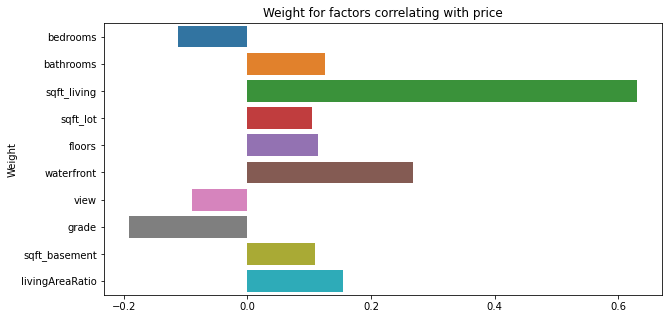

In [48]:
plt.figure(figsize=(10,5))
sns.barplot(y=weights[1::].index, x = weights[1::].values)
plt.title("Weight for factors correlating with price")
plt.ylabel("Weight")
plt.show()

Evaluate R square

In [49]:
results_standardized.rsquared

0.6500261002413503

take a look at the summary:

In [50]:
results_standardized.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     80.05
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           9.32e-92
Time:                        21:32:58   Log-Likelihood:                -394.64
No. Observations:                 442   AIC:                             811.3
Df Residuals:                     431   BIC:                             856.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.158e-17      0.028  -2.16e-15      1.000      -0.056       0.056
bedrooms           -0.1118      0.044     -2.522      0.012      -0.199      -0.025
bathrooms           0.1260      0.044      2.871      0.004       0.040       0.212
sqft_living         0.6296      0.056     11.302      0.000       0.520       0.739
sqft_lot            0.1041      0.035      2.996      0.003       0.036       0.172
floors              0.1142      0.036      3.186      0.002       0.044       0.185
waterfront          0.2685      0.035      7.671      0.000       0.200       0.337
view               -0.0887      0.038     -2.345      0.019      -0.163      -0.014
grade              -0.1908      0.032     -6.029      0.000      -0.253      -0.129
sqft_basement       0.1100      0.035      3.111      0.002       0.041       0.180
livingAreaRatio     0.1551      0.046      3.392      0.001       0.065       0.245
==============================================================================
Omnibus:                      171.316   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1995.456
Skew:                           1.319   Prob(JB):                         0.00
Kurtosis:                      13.069   Cond. No.                         4.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Define the linear regression model

In [51]:
lr = LinearRegression()
lr

LinearRegression()

Traing and Testing

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)


In [53]:
print(len(X_train), len(Y_train))

309 309


Creating our prediction machine

In [54]:
lr.fit(X_train,Y_train)

LinearRegression()

Get the "learned" weights:

In [55]:
lr.coef_

array([-4.92498724e+04,  1.14080437e+05,  2.64547657e+02,  1.09861009e+01,
        8.56850702e+04,  1.02187512e+06, -2.36216240e+04, -2.38695319e+04,
        3.94221253e+01,  3.26957399e+05])

In [56]:
lr.intercept_

-407882.3328092153

In [57]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_basement', 'livingAreaRatio'],
      dtype='object')

get r square on fit.

In [58]:
lr.score(X_train,Y_train)

0.6423260728867994

Evaluating our model on the test data

In [59]:
Y_pred = lr.predict(X_test)
Y_pred[0:10]

array([ 416886.43616589,  592891.66424232,  635721.13345291,
        624666.38851301,  795433.10919949,  629238.21908163,
       1058056.09993285, 2288371.42536783,  825696.32437881,
        543942.35748923])

Evaluate model prediction on test set:

In [60]:
MAE = mean_absolute_error(Y_pred, Y_test)
MAE

177756.03546299567

MAE is 163736.67062067962

In [61]:
RMSE = np.sqrt(mean_squared_error(Y_pred,Y_test))
RMSE

244273.6563080049

RMSE is 207995.66343861358

In [62]:
%%capture price_test
fig, ax = plt.subplots()
Y_test.hist(bins='auto', ax=ax)
ax.set_xlabel("price")
ax.set_ylabel("Counts")
ax.set_title('price expectancy: test distribution')
plt.show()

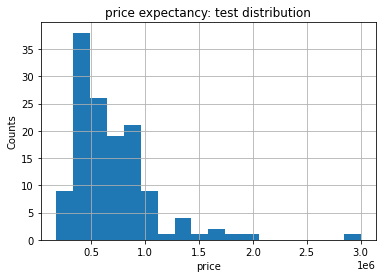

In [63]:
price_test()

Seeing a few individual examples.

In [64]:
examp_idx = 10
single_examp = X_test.iloc[examp_idx].values
X_test.iloc[examp_idx]

bedrooms              3.00000
bathrooms             2.50000
sqft_living        2010.00000
sqft_lot           2212.00000
floors                2.00000
waterfront            0.00000
view                  0.00000
grade                 9.00000
sqft_basement         0.00000
livingAreaRatio       0.90868
Name: 10590, dtype: float64

In [65]:
lr.predict(single_examp.reshape(1,-1))

array([539255.16672245])

In [66]:
Y_test.iloc[examp_idx]

472217.0

try it to a house over 110 year and pricePerSqft more than 300

In [67]:
data[(data['houseAge']>110) & (data['pricePerSqft']>300)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,propertyTaxPerYear,livingAreaRatio,year_sold,houseAge,pricePerSqft
2708,5016002180,2014-07-08,780000.0,2,2.50,2560,2500,2.0,0,0,...,1901,0.0,98112,1890,5000,7878.0,1.024000,2014,113,312.000000
3297,1337800855,2015-05-12,885000.0,3,1.50,2200,2880,2.0,0,0,...,1904,0.0,98112,2440,4640,8938.5,0.763889,2015,111,307.291667
3865,1732800820,2014-06-19,1330000.0,4,2.50,2440,3600,2.5,0,0,...,1902,0.0,98119,2440,5440,13433.0,0.677778,2014,112,369.444444
15283,6169900545,2014-06-25,1330000.0,3,1.50,1940,2885,1.5,0,2,...,1900,0.0,98119,2550,3600,13433.0,0.672444,2014,114,461.005199
15729,9828702895,2014-10-22,700000.0,4,1.75,2420,520,1.5,0,0,...,1900,0.0,98112,1200,1170,7070.0,4.653846,2014,114,1346.153846
17981,1346300035,2014-06-26,1990000.0,5,3.00,4480,5000,2.5,0,0,...,1902,0.0,98112,3220,5600,20099.0,0.896000,2014,112,398.000000
18061,5457800930,2014-06-13,1700000.0,2,2.25,3170,3000,2.0,0,2,...,1900,0.0,98109,2980,5061,17170.0,1.056667,2014,114,566.666667


In [68]:
select_house = data[data['id'] == 5016002180]
select_house[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view','grade', 'sqft_basement', 'livingAreaRatio']]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_basement,livingAreaRatio
2708,780000.0,2,2.5,2560,2500,2.0,0,0,9,870.0,1.024


In [69]:
target_house_dict = {'bedrooms':2, 'bathrooms':2.5, 'sqft_living':2560, 'sqft_lot':2500, 'floors':2, 'waterfront':0, 'view':0, 'grade':9, 'sqft_basement':870.0, 'livingAreaRatio':1.024}
X_target_house = pd.Series(target_house_dict)

convert to numpy array

In [70]:
X_target_house_np = X_target_house.values
X_target_house_np

array([2.000e+00, 2.500e+00, 2.560e+03, 2.500e+03, 2.000e+00, 0.000e+00,
       0.000e+00, 9.000e+00, 8.700e+02, 1.024e+00])

In [71]:
X_target_house_input = X_target_house_np.reshape(1,-1)
X_target_house_input

array([[2.000e+00, 2.500e+00, 2.560e+03, 2.500e+03, 2.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00, 8.700e+02, 1.024e+00]])

The model predicts a price for this old house

In [72]:
lr.predict(X_target_house_input)


array([809172.24753895])

if builder or develop buy this house, the estimated value of this homes is $899101, the list price of this house is $780000. $119101 increaed. 

In [73]:
percent_change = (lr.predict(X_target_house_input)[0] - select_house['price'] ) / select_house['price'] * 100
print(percent_change)

2708    3.740032
Name: price, dtype: float64


$899101 and compare to the distribution

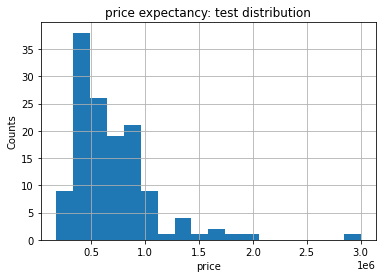

In [74]:
price_test()